# Classification. Linear models and KNN

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import os

In [2]:
np.random.seed(42)

In [3]:
PATH = "./data/"

In [4]:
# reading data
df_train = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv'))
df_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv'))

# data shapes check
print(df_train.shape)
print(df_test.shape)

(595212, 59)
(892816, 58)


In [5]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

![](https://i.stack.imgur.com/Ufea8.gif)

Normalized Gini coefficient is most commonly defined as twice the area between the ROC curve and the diagonal (with this area being taken as negative in the rare event that the curve lies below the diagonal). 
Therefore we have a right triangle with the area of 0.5 (a half of the total plot area). Hence, Gini is equal to Area under ROC curve subtract this right triangle area, 0.5. 

Hence, Gini + 1 = 2AUC, or Gini = 2AUC - 1.

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

I would suggest that we used some balanced metric, like F-score, for example. For us here it is more important to spot all the drivers who will file a claim next year, so it is more important for us to minimize false negatives, i.e. maximize recall of our model, so F2-score would be a suitable metric here. 

F2-Measure = (5 * Precision * Recall) / (4 * Precision + Recall)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [6]:
# assigning some random value to test set rows so that we will be able to find them later
df_test['target'] = 10
# combining train and test to work on a dataset alltogether
df_all = df_train.append(df_test, sort = True)

In [7]:
# let's look at our data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488028 entries, 0 to 892815
Data columns (total 59 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1488028 non-null  int64  
 1   ps_calc_01      1488028 non-null  float64
 2   ps_calc_02      1488028 non-null  float64
 3   ps_calc_03      1488028 non-null  float64
 4   ps_calc_04      1488028 non-null  int64  
 5   ps_calc_05      1488028 non-null  int64  
 6   ps_calc_06      1488028 non-null  int64  
 7   ps_calc_07      1488028 non-null  int64  
 8   ps_calc_08      1488028 non-null  int64  
 9   ps_calc_09      1488028 non-null  int64  
 10  ps_calc_10      1488028 non-null  int64  
 11  ps_calc_11      1488028 non-null  int64  
 12  ps_calc_12      1488028 non-null  int64  
 13  ps_calc_13      1488028 non-null  int64  
 14  ps_calc_14      1488028 non-null  int64  
 15  ps_calc_15_bin  1488028 non-null  int64  
 16  ps_calc_16_bin  1488028 non-null  int

Now it looks like we don't have any missing values but it's not true.

In [8]:
# replacing (-1) with NaN - the description of the dataset says that -1 is a missing value in our case
df_all.replace(-1, np.nan, inplace=True)
# one more summary - not that perfect anymore
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488028 entries, 0 to 892815
Data columns (total 59 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1488028 non-null  int64  
 1   ps_calc_01      1488028 non-null  float64
 2   ps_calc_02      1488028 non-null  float64
 3   ps_calc_03      1488028 non-null  float64
 4   ps_calc_04      1488028 non-null  int64  
 5   ps_calc_05      1488028 non-null  int64  
 6   ps_calc_06      1488028 non-null  int64  
 7   ps_calc_07      1488028 non-null  int64  
 8   ps_calc_08      1488028 non-null  int64  
 9   ps_calc_09      1488028 non-null  int64  
 10  ps_calc_10      1488028 non-null  int64  
 11  ps_calc_11      1488028 non-null  int64  
 12  ps_calc_12      1488028 non-null  int64  
 13  ps_calc_13      1488028 non-null  int64  
 14  ps_calc_14      1488028 non-null  int64  
 15  ps_calc_15_bin  1488028 non-null  int64  
 16  ps_calc_16_bin  1488028 non-null  int

In [9]:
# listing all the categorical features that have NaN values
categorical_na = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',\
          'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat']

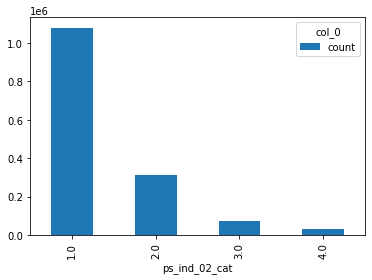

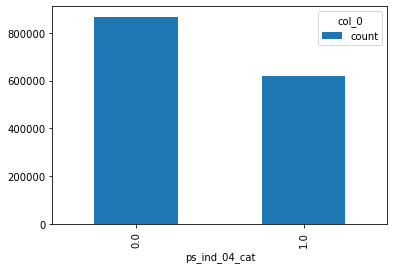

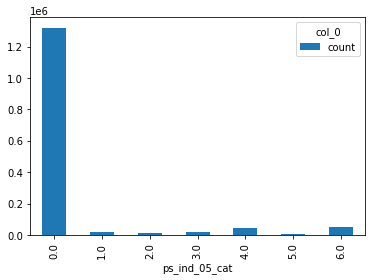

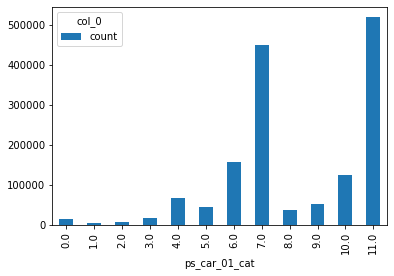

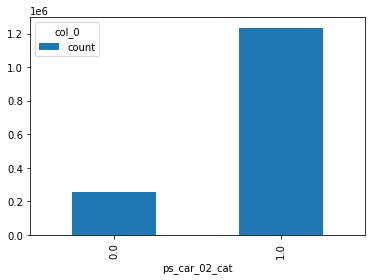

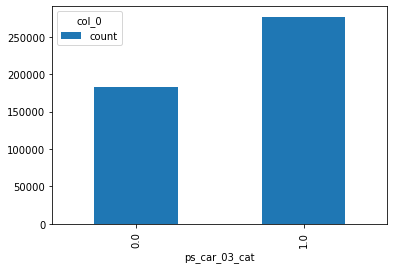

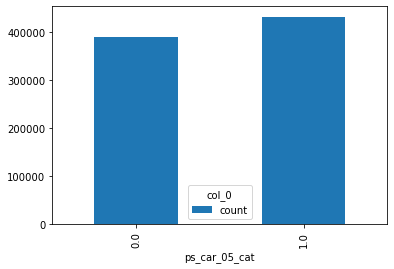

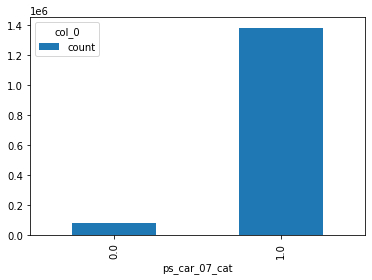

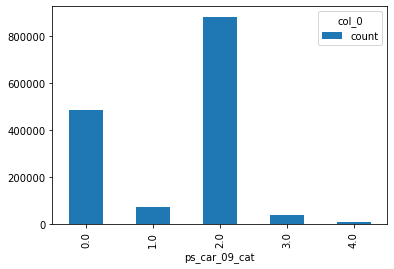

In [10]:
# let's plot the frequency count of each category for each of the categorical variables that contain missing vals
for variable in categorical_na:
    my_tab = pd.crosstab(index = df_all[variable], columns="count")    
    my_tab.plot.bar()
    plt.show()

In every bar chart there is a big difference in the frequency counts for the categories. 
So I suggest that we fill up the missing values with the most common value of the column.

In [11]:
# filling NaNs with the most common value, i.e. mode
for variable in categorical_na:
    df_all[variable] = df_all[variable].fillna(df_all[variable].mode()[0])

In [12]:
# here are all the continuous variables that contain NaN
continuous_na = ['ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_14']
# let's fill NaNs with mean value
for variable in continuous_na:
    df_all[variable] = df_all[variable].fillna(df_all[variable].mean())

In [13]:
# calculating the number of unique values in each column
def count_unique_value(dataframe):
    df = pd.DataFrame()
    df['Unique values count'] = dataframe.nunique()
    df['Type'] = dataframe.dtypes
    return df

print(count_unique_value(df_all))

                Unique values count     Type
id                          1488028    int64
ps_calc_01                       10  float64
ps_calc_02                       10  float64
ps_calc_03                       10  float64
ps_calc_04                        6    int64
ps_calc_05                        7    int64
ps_calc_06                       11    int64
ps_calc_07                       10    int64
ps_calc_08                       12    int64
ps_calc_09                        8    int64
ps_calc_10                       26    int64
ps_calc_11                       21    int64
ps_calc_12                       12    int64
ps_calc_13                       16    int64
ps_calc_14                       25    int64
ps_calc_15_bin                    2    int64
ps_calc_16_bin                    2    int64
ps_calc_17_bin                    2    int64
ps_calc_18_bin                    2    int64
ps_calc_19_bin                    2    int64
ps_calc_20_bin                    2    int64
ps_car_01_

In [14]:
# converting to a categorical variable if a column has less than 20 unique values
def to_categorical(dataframe):
    col = dataframe.columns
    for i in col:
        if dataframe[i].nunique()<=20:
            dataframe[i] = dataframe[i].astype('category')
    
to_categorical(df_all)

# changing target to int64 
df_all['target'] = df_all['target'].astype('int64')

In [15]:
# converting categorical variables to dummies (indicator variables)
df_all_dummy = pd.get_dummies(df_all, drop_first = True)

In [16]:
# splitting back to training and test sets (that's where our target=10 comes in handy)
df_train_adj = df_all_dummy[df_all_dummy['target'] != 10]
df_test_adj = df_all_dummy[df_all_dummy['target'] == 10]

In [17]:
# splitting training set to X and y
X = df_train_adj.drop(['target','id'], axis = 1)
#Extract labels from training set
y = df_train_adj['target']

In [18]:
# Logistic Regression model with robust scaler
logreg = make_pipeline(RobustScaler(), LogisticRegression(solver='liblinear', max_iter=100))

In [19]:
# checking model performance
score = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

In [20]:
print("\nLogistic Regression Score: {:.5f} ({:.5f})\n".format(score.mean(), score.std()))
print(f"Normalized Gini {2*score.mean() - 1}")


Logistic Regression Score: 0.63367 (0.00214)

Normalized Gini 0.26734657023509145


In [21]:
# submission preparation
test_df_x = df_test_adj.drop(['target', 'id'], axis = 1)
logreg.fit(X, y)

# predicting probability
test_df_y = logreg.predict_proba(test_df_x)[:,1]

In [22]:
temp = pd.DataFrame(pd.read_csv(os.path.join(PATH, 'porto', 'test.csv'))['id'])

In [23]:
temp['target'] = test_df_y
temp.to_csv("submission2.csv", index = False)
# and we our ready to rock!# and we our ready to rock!

public Kaggle leaderboard score: 0.26671

private Kaggle leaderboard score: 0.27073

https://www.kaggle.com/k8isdead

Ekaterina Martynko

![](https://sun9-8.userapi.com/impf/wso9a7e5fq87d-XsD7c3cLw4L-h_sKpVHc8JCg/qKtWuI_K93M.jpg?size=861x209&quality=96&sign=987746432c3b389aa7a9a6d3865441f6&type=album)